# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda, Add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

Using TensorFlow backend.


In [118]:
from ccs_tools import dx_label

## Data Preparation

In [5]:
cohort='ami'
tst_seed=0

In [492]:
all_df = pd.read_csv(path+'cohorts20/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)

In [127]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [493]:
freq = get_frequency(all_df)

In [494]:
DX1_rarecutpoint = 100
DX_rarecutpoint = 100
PR_rarecutpoint = 100

In [495]:
infreq_DX1 = sorted(freq['DX1'].loc[freq['DX1']<DX1_rarecutpoint].index)
infreq_DX = sorted(freq['DX'].loc[freq['DX']<DX_rarecutpoint].index)
infreq_PR = sorted(freq['PR'].loc[freq['PR']<PR_rarecutpoint].index)

In [496]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [238]:
len(all_df)

184993

In [497]:
DX1_out = set(infreq_DX1).union(set(unclassified))
DX_out = set(infreq_DX).union(set(unclassified))
PR_out = set(infreq_PR)

In [498]:
clean_df = all_df.loc[~all_df.DX1.isin(DX1_out)]

for dx in DXs:
    clean_df = clean_df.loc[~clean_df[dx].isin(DX_out)]

for pr in PRs:
    clean_df = clean_df.loc[~clean_df[pr].isin(PR_out)]

In [241]:
len(clean_df)

111619

In [499]:
hosp_freq = clean_df.HOSP_NRD.value_counts()
hosp_in = hosp_freq.loc[hosp_freq>=10].index

In [500]:
all_df = clean_df.loc[clean_df.HOSP_NRD.isin(hosp_in)]

In [501]:
len(all_df)

87202

In [502]:
preprocessed = preprocess(all_df, DX_rarecutpoint=0, PR_rarecutpoint=0)

In [503]:
all_df = preprocessed['int_df'].reset_index(drop=True)

In [11]:
tst_key = pd.read_csv(path+'cohorts20/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [17]:
train_df0.shape, all_df.shape

((166058, 184), (184993, 183))

In [143]:
from sklearn.model_selection import StratifiedKFold

In [504]:
skf = StratifiedKFold(n_splits=10, random_state=24, shuffle=True)

In [505]:
train_idx, tst_idx = next(skf.split(all_df, all_df.HOSP_NRD))

In [506]:
train_df0 = all_df.loc[train_idx].reset_index(drop=True)
tst_df = all_df.loc[tst_idx].reset_index(drop=True)

In [294]:
train_df0.shape, tst_df.shape

((95532, 183), (11078, 183))

## Multi-Level CCS Codes

### Create the parent pairs

Read the ICD9 CCS multi-level category dictionary file. 

In [12]:
from ccs_tools import dx_label

In [22]:
rare_desc = icd_dict.loc[icd_dict.dgns_cd.isin(rare_code), ['dgns_cd', 'longdesc']]

In [23]:
rare_desc.to_csv(path+'rare_icd9.csv', index=False)

In [31]:
dx_multi.CCS_LVL1_LABEL.value_counts()

Injury and poisoning                                                                 2764
Residual codes; unclassified; all E codes [259. and 260.]                            1589
Diseases of the nervous system and sense organs                                      1587
Infectious and parasitic diseases                                                    1226
Complications of pregnancy; childbirth; and the puerperium                           1205
Neoplasms                                                                            1114
Diseases of the musculoskeletal system and connective tissue                          863
Diseases of the digestive system                                                      757
Mental Illness                                                                        597
Diseases of the circulatory system                                                    553
Diseases of the genitourinary system                                                  498
Endocrine;

## Embedding + NN

### Train embedding with Glove

In [82]:
from glove import Glove

In [148]:
embed_dim=100
count_cap=5

In [507]:
g = Glove(input_dim=len(preprocessed['code_cat']), embedding_dim=embed_dim, count_cap=count_cap)

In [508]:
g.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 78066 rows...
Finished. It takes 15.1 seconds to update the cooccurrences.


In [509]:
cooccur_df = g.get_cooccur_df()

In [314]:
cooccur_df.shape

(586066, 3)

In [510]:
parent_pairs = preprocessed['parent_pairs']

In [511]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=80, earlystop_patience=10, reducelr_patience=3, 
              parent_pairs=parent_pairs, lamb=0., metric='cosine', batch_size=1024*4)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/80
283451/283451 [==============================] - 4s 15us/step - loss: 3.8116
Epoch 2/80
283451/283451 [==============================] - 0s 2us/step - loss: 2.3740
Epoch 3/80
283451/283451 [==============================] - 0s 2us/step - loss: 0.7994
Epoch 4/80
283451/283451 [==============================] - 1s 2us/step - loss: 0.4223
Epoch 5/80
283451/283451 [==============================] - 0s 2us/step - loss: 0.3284
Epoch 6/80
283451/283451 [==============================] - 0s 2us/step - loss: 0.2984
Epoch 7/80
283451/283451 [==============================] - 0s 2us/step - loss: 0.2838
Epoch 8/80
283451/283451 [==============================] - 0s 2us/step - loss: 0.2721
Epoch 9/80
283451/283451 [==============================] - 0s 2us/step - loss: 0.2597
Epoch 10/80
283451/283451 [==============================] - 0s 2us/step - loss: 0.2465
Epoch 11/80
283451/283451 [===========================

In [512]:
embed_mat = g.get_embed_mat()

In [316]:
embed_mat.shape

(3622, 100)

In [237]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [238]:
code_freq = get_frequency(train_df0)

In [239]:
DX_freq = code_freq['DX']

In [240]:
DX_embed_mat = embed_mat[DX_dict[DX_cat[0]]:(DX_dict[DX_cat[-1]]+1), :]

In [306]:
DX_embed_mat = embed_mat[1:(DX_dict[DX_cat[-1]]+1), :]

In [300]:
tsne = TSNE(n_components=2, init='random', random_state=0)

In [307]:
start = time.time()
DX_tsne = tsne.fit_transform(DX_embed_mat)
print('Time used: {} sec'.format(time.time()-start))

Time used: 12.048529148101807 sec


In [243]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=DX_cat)

In [321]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=['m'+dx for dx in DX1_cat]+DX_cat)

CCS category labels:

In [244]:
plot_df = plot_df.assign(ccs_lvl1=[dx_multi.loc[dx, 'CCS_LVL1']+' '+dx_multi.loc[dx, 'CCS_LVL1_LABEL'] for dx in plot_df.index])

plot_df = plot_df.assign(freq=DX_freq.loc[pd.Series(DX_cat).apply(lambda x:DX_dict[x])].values)

plot_df = plot_df.assign(dot_size=plot_df.freq.apply(lambda x:np.log(x+1)**2/4))

In [310]:
plot_df = plot_df.assign(label='other')

In [320]:
plot_df.loc['41001']

x          y  label
41001  3.324308  10.902804  major
41001 -0.376500   1.508393  other

In [322]:
plot_df.head(30)

x          y
m41000   5.994010 -13.867500
m41001   3.324308  10.902804
m41010  -5.964371  -5.004744
m41011   3.358795  11.083466
m41020   5.888000 -13.817354
m41021   3.266266  10.813693
m41030  10.456566 -14.355887
m41031   3.254933  10.763239
m41040   4.830407 -15.705278
m41041   2.996257  11.277818
m41050  12.145478  -6.577780
m41051   3.137660  10.620467
m41060   9.797898 -12.790399
m41061   2.303349   7.326526
m41070 -12.708771  -2.968350
m41071   1.310318  13.164182
m41080  11.018405 -13.890571
m41081   1.539214   6.538039
m41090  -1.650072  -4.472263
m41091   2.256572  12.647313
00845    8.867237  10.019275
0088    -3.082910   0.376406
0090    -3.067797   4.014546
0340    11.605210 -11.665422
0380     7.734156   1.162930
03811    8.244345   0.877406
03812    8.600551   0.538114
03819    8.917855  -0.005611
03840    9.302263   1.126356
03842    7.652380   1.565716

In [245]:
groups = plot_df.groupby('ccs_lvl1')
gkey = groups.size().sort_values(ascending=False).index

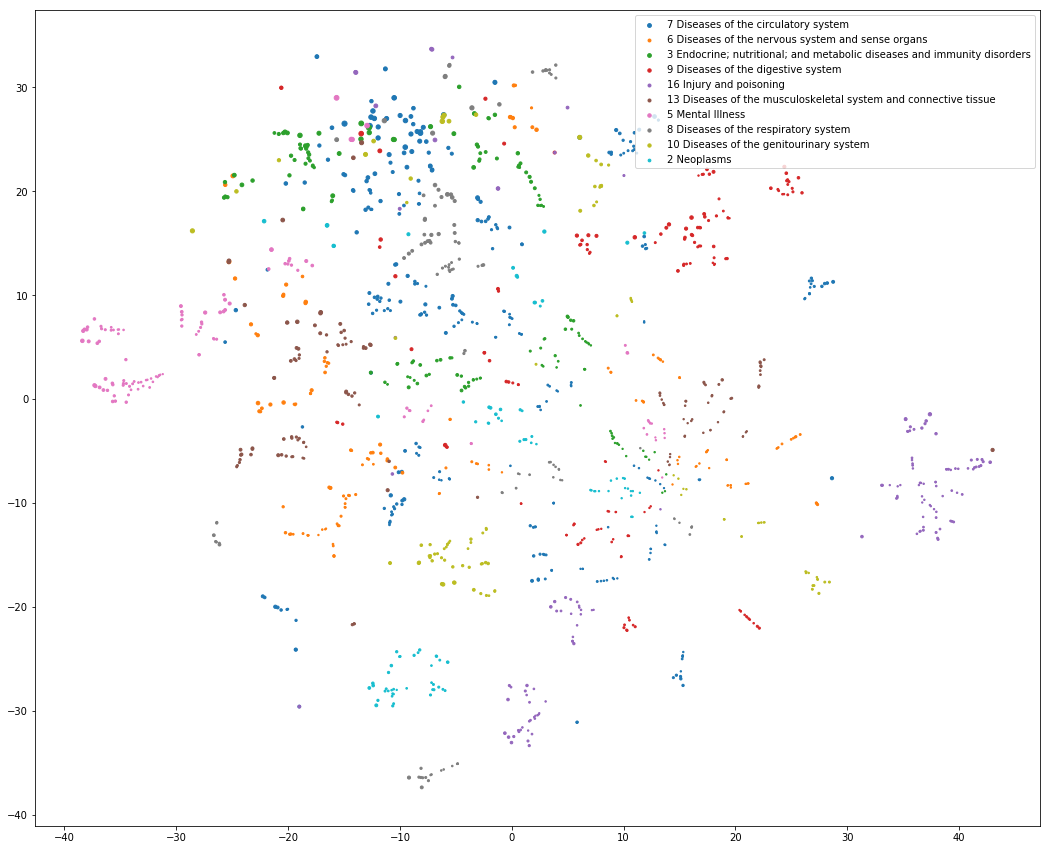

In [102]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in gkey[:10]:
    group = groups.get_group(name)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=name)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('output/embed.png', dpi=200)

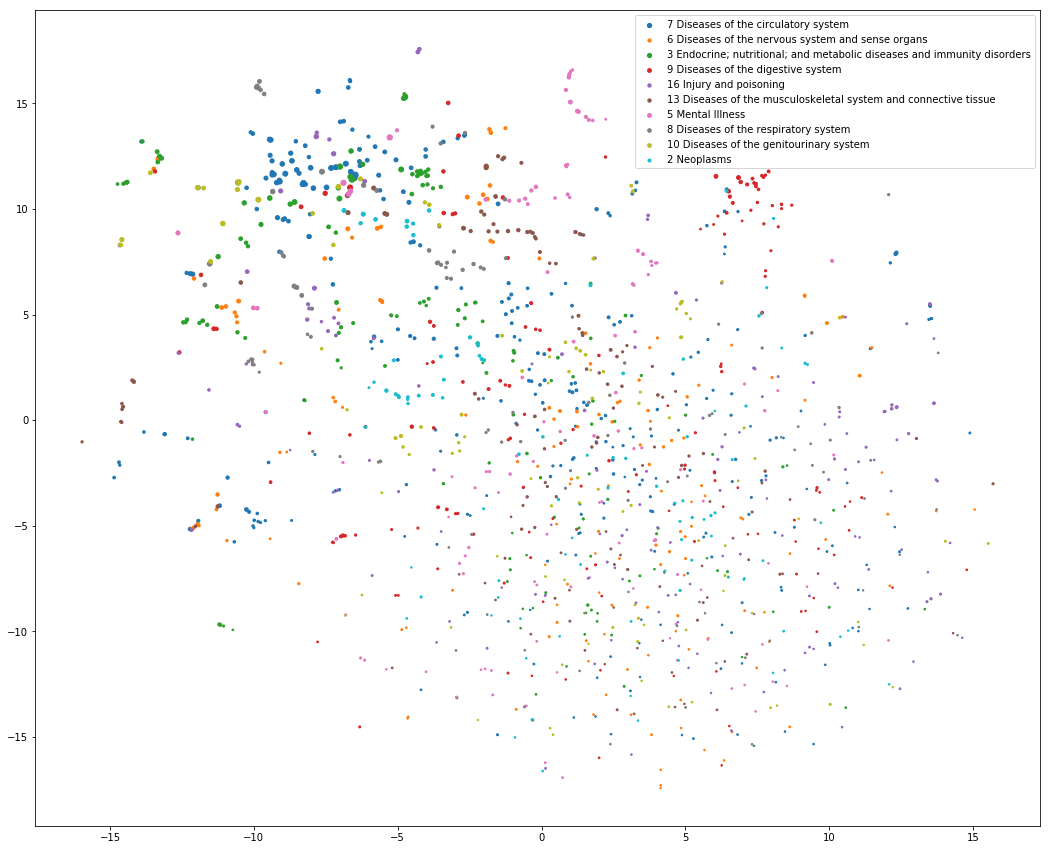

In [246]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in gkey[:10]:
    group = groups.get_group(name)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=name)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('output/embed.png', dpi=200)

In [26]:
bias_mat = g.get_bias_mat()

In [28]:
all_freq = pd.concat([code_freq['DX1'], code_freq['DX'], code_freq['PR']], axis=0)

In [29]:
all_freq = all_freq.sort_index().drop(0)

In [30]:
code_bias_mat = bias_mat[1:(len(DX1_cat)+len(DX_cat)+len(PR_cat)+1), :]

In [32]:
code_bias_mat.shape, all_freq.shape

((2134, 1), (2134,))

In [38]:
from collections import defaultdict

In [39]:
marg_dict = defaultdict(float)

for _, row in cooccur_df.iterrows():
    marg_dict[row.focal_index] += row.cooccur_counts
    marg_dict[row.context_index] += row.cooccur_counts

In [51]:
marg_freq = np.array(list(marg_dict.values()))

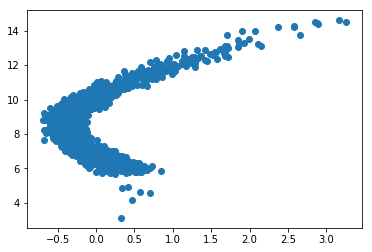

In [54]:
plt.scatter(code_bias_mat[:, 0], np.log(marg_freq))

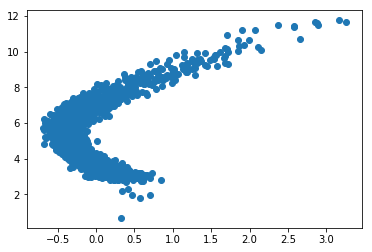

In [56]:
plt.scatter(code_bias_mat[:, 0], np.log(all_freq.values))

In [57]:
cooccur_df.head()

focal_index  context_index  cooccur_counts
0         1151            604             2.0
1         1082            437            13.0
2         1428            153            11.0
3         1117            103             6.0
4         1006            901             3.0

### Data formating

In [513]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

DX1_array_tst = tst_df['DX1'].values
DX_mat_tst = tst_df[DXs].values
PR_mat_tst = tst_df[PRs].values

hosp_array_tst = tst_df['HOSP_NRD'].values
    
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [514]:
train_df = train_df0.copy()

In [515]:
n_fold = 5

In [516]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [517]:
trn_idx, val_idx = next(skf.split(train_df, train_df0.HOSP_NRD))

In [518]:
DX1_array_train = train_df['DX1'].values
            
DX1_array_trn = DX1_array_train[trn_idx]
DX1_array_val = DX1_array_train[val_idx]

DX_mat_train = train_df[DXs].values
            
DX_mat_trn = DX_mat_train[trn_idx, :]
DX_mat_val = DX_mat_train[val_idx, :]

PR_mat_train = train_df[PRs].values
            
PR_mat_trn = PR_mat_train[trn_idx, :]
PR_mat_val = PR_mat_train[val_idx, :]

In [519]:
hosp_array_train = train_df['HOSP_NRD'].values
    
hosp_array_trn = hosp_array_train[trn_idx]
hosp_array_val = hosp_array_train[val_idx]

In [520]:
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]
#transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                ed_mat_train, zipinc_mat_train), axis=1)

other_mat_trn = other_mat_train[trn_idx, :]
other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
y_trn = y_train[trn_idx]
y_val = y_train[val_idx]
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

### Model Building

In [99]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling

In [30]:
from keras_multi_head import MultiHeadAttention

In [211]:
code_embed_dim = 100
md_width = 64
fc_width = 512
hosp_embed_dim = 1
dropout = 0.3
job_index = 0
batchsize = 512

In [114]:
n_heads = 8
n_att_layers = 24

In [521]:
embed_initializer = Constant(embed_mat)

In [130]:
embed_initializer = 'uniform'

Model building: 
- setsum_nn 
- setsum_lr
- embed_sum
- embed_pool

In [102]:
model_name = 'setsum_nn'

In [522]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                      name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (len(DXs),))
DX_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
if model_name=='setsum_nn' or 'setsum_lr':
    DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_sum':
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_pool':
    DX_embed = MaskedPooling()(DX_embed)
input_PR = Input(shape = (len(PRs),))
PR_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='PR_embed')(input_PR)
if model_name=='setsum_nn' or 'setsum_lr':
    PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_sum':
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_pool':
    PR_embed = MaskedPooling()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
if model_name=='setsum_nn':
    merged = Dense(fc_width, activation='relu')(merged)
    merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

Trying multi-head attention:

In [115]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                      name='DX1_embed')(input_DX1)
#DX1_embed = Reshape((code_embed_dim,))(DX1_embed)

input_DX = Input(shape = (len(DXs),))
DX_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)

input_PR = Input(shape = (len(PRs),))
PR_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='PR_embed')(input_PR)

code_embed = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed])
for j in range(n_att_layers):
    att = MultiHeadAttention(head_num=n_heads, use_bias=False, activation='linear')(code_embed)
    code_embed = Add()([code_embed, att])
    #code_embed = Dropout(0.3)(code_embed)
    #code_embed = MultiHeadAttention(head_num=n_heads, use_bias=False, activation='linear')(code_embed)
    code_embed = BatchNormalization()(code_embed)
#code_embed = MaskedSum()(code_embed)
code_embed = Lambda(lambda x:x[:, 0, :])(code_embed)
#DX_embed = Reshape((1, code_embed_dim))(DX_embed)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))
merged = Concatenate(axis=1)([code_embed, hosp_embed, input_other])
#merged = Dense(fc_width, activation='relu')(merged)
#merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [523]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = False

In [524]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [530]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = True

In [531]:
adam = Adam(lr=0.00002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [532]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_temp'+str(job_index)+'.h5', validation_y=Y_val[:, 1], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [454]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [533]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=30, callbacks=[auccheckpoint, reduce_lr, earlystop], 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                    verbose=1)

Train on 62090 samples, validate on 15976 samples
Epoch 1/30
62090/62090 [==============================] - 6s 104us/step - loss: 0.3077 - val_loss: 0.3170
AUC: 0.7102

Epoch 2/30
62090/62090 [==============================] - 2s 25us/step - loss: 0.3075 - val_loss: 0.3171
AUC: 0.7104

Epoch 3/30
62090/62090 [==============================] - 1s 23us/step - loss: 0.3072 - val_loss: 0.3171
AUC: 0.7105

Epoch 4/30
62090/62090 [==============================] - 1s 24us/step - loss: 0.3070 - val_loss: 0.3172
AUC: 0.7103

Epoch 5/30
62090/62090 [==============================] - 1s 24us/step - loss: 0.3063 - val_loss: 0.3171
AUC: 0.7104

Epoch 6/30
62090/62090 [==============================] - 1s 23us/step - loss: 0.3060 - val_loss: 0.3171
AUC: 0.7107

Epoch 7/30
62090/62090 [==============================] - 1s 24us/step - loss: 0.3056 - val_loss: 0.3172
AUC: 0.7106

Epoch 8/30
62090/62090 [==============================] - 1s 23us/step - loss: 0.3055 - val_loss: 0.3172
AUC: 0.7106

Epoch

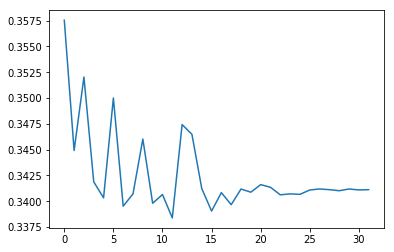

In [105]:
plt.plot(hist.history['val_loss'])

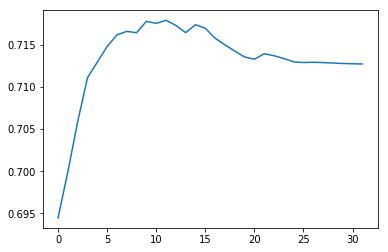

In [106]:
plt.plot(auccheckpoint.auc_history)

In [534]:
model.load_weights(model_path+'embeding_nn_temp'+str(job_index)+'.h5')

In [535]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

9136/9136 [==============================] - 1s 65us/step


{0: 0.7176888576409813}

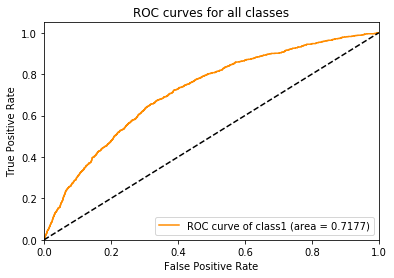

In [536]:
plot_roc(y_pred, y_true)

In [170]:
for l in model.layers:
    if l.name=='DX_embed':
        embed_mat_trained = l.get_weights()[0]

### Less predictors

In [248]:
model_name = 'setsum_nn'

In [274]:
embed_initializer = 'uniform'

In [249]:
embed_initializer = Constant(embed_mat)

In [250]:
code_embed_dim = 100
md_width = 128

In [286]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                      name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (len(DXs),))
DX_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
if model_name=='setsum_nn' or 'setsum_lr':
    DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_sum':
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_pool':
    DX_embed = MaskedPooling()(DX_embed)
input_PR = Input(shape = (len(PRs),))
PR_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='PR_embed')(input_PR)
if model_name=='setsum_nn' or 'setsum_lr':
    PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_sum':
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_pool':
    PR_embed = MaskedPooling()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed])
if model_name=='setsum_nn':
    merged = Dense(fc_width, activation='relu')(merged)
    merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp], outputs=prediction)

In [287]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed':
        l.trainable = False

In [288]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [289]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_temp'+str(job_index)+'.h5', validation_y=Y_val[:, 1], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [290]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [291]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn], Y_trn, 
                     batch_size=batchsize, epochs=30, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val], Y_val], 
                    verbose=1)

Train on 133832 samples, validate on 34009 samples
Epoch 1/30
133832/133832 [==============================] - 4s 27us/step - loss: 1.2962 - val_loss: 0.6593
AUC: 0.6928

Epoch 2/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2701 - val_loss: 0.6217
AUC: 0.6995

Epoch 3/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2605 - val_loss: 0.6324
AUC: 0.7031

Epoch 4/30
133832/133832 [==============================] - 2s 15us/step - loss: 1.2536 - val_loss: 0.6406
AUC: 0.7056

Epoch 5/30
133832/133832 [==============================] - 2s 15us/step - loss: 1.2472 - val_loss: 0.5979
AUC: 0.7069

Epoch 6/30
133832/133832 [==============================] - 2s 15us/step - loss: 1.2405 - val_loss: 0.6093
AUC: 0.7078

Epoch 7/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2342 - val_loss: 0.5931
AUC: 0.7070

Epoch 8/30
133832/133832 [==============================] - 2s 14us/step - loss: 1.2295 - val_loss: 0.6434
AU

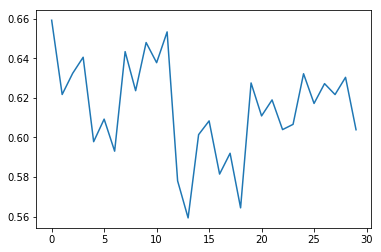

In [292]:
plt.plot(hist.history['val_loss'])

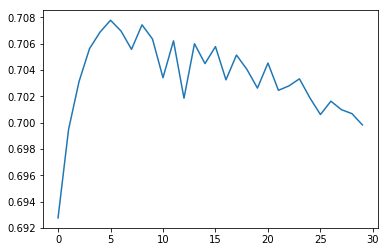

In [293]:
plt.plot(auccheckpoint.auc_history)

In [294]:
model.load_weights(model_path+'embeding_nn_temp'+str(job_index)+'.h5')

In [295]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

19214/19214 [==============================] - 1s 50us/step


{0: 0.701814176877337}

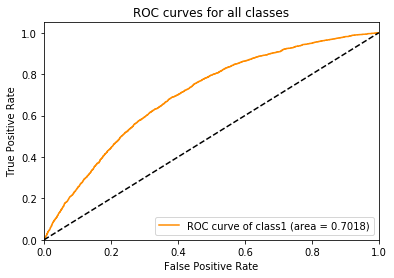

In [296]:
plot_roc(y_pred, y_true)

## Train with One-Hot-Encoding

In [12]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

In [13]:
code_mat_tst = tst_df[['DX1']+DXs+PRs].values
code_ohe_tst = np.zeros((len(tst_df), len(code_cat)))
for i in range(code_mat_tst.shape[0]):
    for j in range(code_mat_tst.shape[1]):
        if not code_mat_tst[i,j]==0:
            code_ohe_tst[i, code_mat_tst[i,j]] = 1.

In [14]:
hosp_array_tst = tst_df['HOSP_NRD'].values
hosp_ohe_tst = np.zeros((len(tst_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_tst):
    hosp_ohe_tst[j, hosp] = 1.

In [15]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [18]:
n_fold=3

In [19]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [20]:
trn_idx, val_idx = next(skf.split(train_df0, train_df0.HOSP_NRD))

In [21]:
train_df = train_df0.copy()

In [22]:
code_mat_train = train_df[['DX1']+DXs+PRs].values
code_ohe_train = np.zeros((len(train_df), len(code_cat)))
for i in range(code_mat_train.shape[0]):
    for j in range(code_mat_train.shape[1]):
        if not code_mat_train[i,j]==0:
            code_ohe_train[i, code_mat_train[i,j]] = 1.
            
code_ohe_trn = code_ohe_train[trn_idx, :]
code_ohe_val = code_ohe_train[val_idx, :]

In [23]:
hosp_array_train = train_df['HOSP_NRD'].values
hosp_ohe_train = np.zeros((len(train_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_train):
    hosp_ohe_train[j, hosp] = 1.
    
hosp_ohe_trn = hosp_ohe_train[trn_idx, :]
hosp_ohe_val = hosp_ohe_train[val_idx, :]

In [24]:
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                ed_mat_train, zipinc_mat_train, transfer_mat_train), axis=1)

other_mat_trn = other_mat_train[trn_idx, :]
other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

### Model Building

In [16]:
fc_width1 = 1024
fc_width2 = 256
dropout = 0.3
lr = 1e-4
batchsize = 512

In [25]:
input_code = Input(shape = (len(code_cat),))
input_hosp = Input(shape=(len(hosp_cat),))
input_other = Input(shape=(other_mat_train.shape[1], ))

merged = Concatenate(axis=1)([input_code, input_hosp, input_other])

x = Dense(fc_width1, activation='relu')(merged)
x = Dense(fc_width2, activation='relu')(x)
x = Dropout(dropout)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_code, input_hosp, input_other], outputs=prediction)

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3525)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 959)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 23)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 4507)         0           input_3[0][0]                    
                                                                 input_4[0][0]                    
          

In [95]:
adam = Adam(lr=lr)
model.compile(optimizer=adam, loss='categorical_crossentropy')    

In [96]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'ohe_temp.h5', validation_y=Y_val[:, 1], 
                            validation_x=[code_ohe_val, hosp_ohe_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [97]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [98]:
hist = model.fit([code_ohe_trn, hosp_ohe_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=5, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[code_ohe_val, hosp_ohe_val, other_mat_val], Y_val], verbose=1)

Train on 111558 samples, validate on 56283 samples
Epoch 1/5
111558/111558 [==============================] - 6s 55us/step - loss: 1.2705 - val_loss: 0.6081
AUC: 0.7145

Epoch 2/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.2121 - val_loss: 0.6304
AUC: 0.7153

Epoch 3/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.1628 - val_loss: 0.6129
AUC: 0.7097

Epoch 4/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.0916 - val_loss: 0.6359
AUC: 0.6957

Epoch 5/5
111558/111558 [==============================] - 5s 47us/step - loss: 0.9802 - val_loss: 0.5691
AUC: 0.6664



In [99]:
model.load_weights(model_path+'ohe_temp.h5')

In [100]:
y_output = model.predict([code_ohe_tst, hosp_ohe_tst, other_mat_tst], verbose=0)  

In [104]:
y_pred = y_output[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

In [105]:
roc_auc

0.7117707427053499

## Multi-Space GloVe

In [12]:
from glove import GloveMS

In [112]:
DX1_dim = 5
DX_dim = 100
PR_dim = 40
count_cap = 5
n_fold = 7
hosp_embed_dim = 1
fc_width = 128
dropout = 0.3
lr1 = 2e-4
lr2 = 2e-5
batchsize = 128

In [91]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']

n_DX1_cat = len(DX1_cat)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

n_DX = 29
n_PR = 15
DXs = ['DX'+str(j) for j in range(2, n_DX+2)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [113]:
gms = GloveMS(n_DX1_cat=n_DX1_cat, n_DX_cat=n_DX_cat, n_PR_cat=n_PR_cat, DX1_dim=DX1_dim, DX_dim=DX_dim, PR_dim=PR_dim, 
              count_cap=count_cap, scaling_factor=0.75)

In [75]:
gms.update_cooccur(train_df0[['DX1']+DXs+PRs])

cooccur_df = gms.get_cooccur_df()

Updating co-occurrence matrix from a Dataframe with 167841 rows...
Finished. It takes 36.9 seconds to update the cooccurrences.


In [114]:
gms.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=50, earlystop_patience=10, reducelr_patience=2, verbose=2)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/50
 - 22s - loss: 0.8345
Epoch 2/50
 - 20s - loss: 0.2112
Epoch 3/50
 - 20s - loss: 0.1570
Epoch 4/50
 - 20s - loss: 0.1345
Epoch 5/50
 - 20s - loss: 0.1201
Epoch 6/50
 - 20s - loss: 0.1101
Epoch 7/50
 - 20s - loss: 0.1026
Epoch 8/50
 - 20s - loss: 0.0969
Epoch 9/50
 - 20s - loss: 0.0924
Epoch 10/50
 - 20s - loss: 0.0886
Epoch 11/50
 - 20s - loss: 0.0856
Epoch 12/50
 - 20s - loss: 0.0832
Epoch 13/50
 - 20s - loss: 0.0811
Epoch 14/50
 - 20s - loss: 0.0796
Epoch 15/50
 - 20s - loss: 0.0783
Epoch 16/50
 - 20s - loss: 0.0772
Epoch 17/50
 - 20s - loss: 0.0764
Epoch 18/50
 - 20s - loss: 0.0757
Epoch 19/50
 - 20s - loss: 0.0750
Epoch 20/50
 - 20s - loss: 0.0746
Epoch 21/50
 - 20s - loss: 0.0740
Epoch 22/50
 - 20s - loss: 0.0737
Epoch 23/50
 - 20s - loss: 0.0733
Epoch 24/50
 - 20s - loss: 0.0729
Epoch 25/50
 - 20s - loss: 0.0726
Epoch 26/50
 - 20s - loss: 0.0723
Epoch 27/50
 - 20s - loss: 0.0722
Epoch 28/50
 - 20

In [95]:
embeds = gms.get_embed_mat()

In [79]:
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()
n_pay1 = int(train_df0['PAY1'].max())+1
n_ed = int(train_df0['HCUP_ED'].max())+1
n_zipinc = int(train_df0['ZIPINC_QRTL'].max())+1

DX1_array_tst = tst_df['DX1'].values
DX_mat_tst = np.maximum(tst_df[DXs].values - n_DX1_cat, 0)
PR_mat_tst = np.maximum(tst_df[PRs].values - n_DX1_cat - n_DX_cat, 0)
hosp_array_tst = tst_df['HOSP_NRD'].values
    
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [104]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)
trn_idx, val_idx = next(skf.split(train_df0, train_df0.HOSP_NRD))

In [105]:
train_df = train_df0.copy()
DX1_array_train = train_df['DX1'].values
DX1_array_trn = DX1_array_train[trn_idx]
DX1_array_val = DX1_array_train[val_idx]

DX_mat_train = np.maximum(train_df[DXs].values - n_DX1_cat, 0)
DX_mat_trn = DX_mat_train[trn_idx, :]
DX_mat_val = DX_mat_train[val_idx, :]

PR_mat_train = np.maximum(train_df[PRs].values - n_DX1_cat - n_DX_cat, 0)
PR_mat_trn = PR_mat_train[trn_idx, :]
PR_mat_val = PR_mat_train[val_idx, :]
    
hosp_array_train = train_df['HOSP_NRD'].values
hosp_array_trn = hosp_array_train[trn_idx]
hosp_array_val = hosp_array_train[val_idx]
    
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                    ed_mat_train, zipinc_mat_train), axis=1)
other_mat_trn = other_mat_train[trn_idx, :]
other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

In [32]:
from setsum_layer import MaskedDense, MaskedSum

In [106]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_DX1_cat+1, output_dim=DX1_dim, embeddings_initializer=Constant(embeds['DX1_embed']), 
                              name='DX1_embed')(input_DX1)     
DX1_embed = Reshape((DX1_dim,))(DX1_embed)
input_DX = Input(shape = (len(DXs),))
DX_embed = Embedding(input_dim=n_DX_cat+1, output_dim=DX_dim, mask_zero=True, 
                     embeddings_initializer=Constant(embeds['DX_embed']), name='DX_embed')(input_DX)
DX_embed = MaskedDense(DX_dim, activation='relu')(DX_embed)
DX_embed = MaskedSum()(DX_embed)
input_PR = Input(shape = (len(PRs),))
PR_embed = Embedding(input_dim=n_PR_cat+1, output_dim=PR_dim, mask_zero=True, 
                     embeddings_initializer=Constant(embeds['PR_embed']), name='PR_embed')(input_PR)
PR_embed = MaskedDense(PR_dim, activation='relu')(PR_embed)
PR_embed = MaskedSum()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
merged = Dense(fc_width, activation='relu')(merged)
merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)  

In [107]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = False
            
adam = Adam(lr=lr1)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [108]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_sub_temp1.h5', validation_y=Y_val[:, 1], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [109]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=30, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                    verbose=1)

Train on 143376 samples, validate on 24465 samples
Epoch 1/30
143376/143376 [==============================] - 7s 50us/step - loss: 1.3147 - val_loss: 0.6223
AUC: 0.7032

Epoch 2/30
143376/143376 [==============================] - 5s 37us/step - loss: 1.2663 - val_loss: 0.6354
AUC: 0.7080

Epoch 3/30
143376/143376 [==============================] - 5s 37us/step - loss: 1.2580 - val_loss: 0.6174
AUC: 0.7115

Epoch 4/30
143376/143376 [==============================] - 5s 37us/step - loss: 1.2519 - val_loss: 0.6577
AUC: 0.7120

Epoch 5/30
143376/143376 [==============================] - 5s 37us/step - loss: 1.2474 - val_loss: 0.6383
AUC: 0.7141

Epoch 6/30
143376/143376 [==============================] - 5s 37us/step - loss: 1.2433 - val_loss: 0.6005
AUC: 0.7155

Epoch 7/30
143376/143376 [==============================] - 5s 37us/step - loss: 1.2399 - val_loss: 0.6122
AUC: 0.7162

Epoch 8/30
143376/143376 [==============================] - 5s 37us/step - loss: 1.2348 - val_loss: 0.6184
AU

In [110]:
model.load_weights(model_path+'embeding_nn_sub_temp1.h5')
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=0)

In [111]:
y_pred = y[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_pred)
auc(fpr, tpr)

0.713009823826124

In [102]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = True
adam = Adam(lr=lr2)
model.compile(optimizer=adam, loss='categorical_crossentropy')
    
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_sub_temp2.h5', validation_y=Y_val[:, 1], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=20, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                    verbose=1)

Train on 143376 samples, validate on 24465 samples
Epoch 1/20
143376/143376 [==============================] - 8s 57us/step - loss: 1.2154 - val_loss: 0.6076
AUC: 0.7179

Epoch 2/20
143376/143376 [==============================] - 6s 45us/step - loss: 1.2140 - val_loss: 0.6152
AUC: 0.7177

Epoch 3/20
143376/143376 [==============================] - 6s 45us/step - loss: 1.2108 - val_loss: 0.6069
AUC: 0.7176

Epoch 4/20
143376/143376 [==============================] - 6s 45us/step - loss: 1.2101 - val_loss: 0.6146
AUC: 0.7179

Epoch 5/20
143376/143376 [==============================] - 6s 45us/step - loss: 1.2101 - val_loss: 0.6177
AUC: 0.7178

Epoch 6/20
143376/143376 [==============================] - 6s 45us/step - loss: 1.2085 - val_loss: 0.6083
AUC: 0.7177

Epoch 7/20
143376/143376 [==============================] - 6s 45us/step - loss: 1.2065 - val_loss: 0.6068
AUC: 0.7179

Epoch 8/20
143376/143376 [==============================] - 6s 45us/step - loss: 1.2073 - val_loss: 0.6279
AU

In [103]:
model.load_weights(model_path+'embeding_nn_sub_temp2.h5')    
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=0)
y_pred = y[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_pred)
auc(fpr, tpr)

0.7145367137051865

### Model checkup

In [5]:
model_name = 'att_lr'
code_embed_dim = 256
#DX1_dim = args.DX1_dim
#DX_dim = args.DX_dim
#PR_dim = args.PR_dim
hosp_embed_dim = 1
fc_width = 512
#md_width = args.md_width
lr1 = 2e-4
lr2 = 5e-5
dropout = 0.3
batchsize = 512
embed_file = 'pretrain'
cohort = 'ami'
tst_seed = 0
n_fold = 5
result_file = 'inapp'
penalty = 0
penalty_metric = 'cosine'
count_cap = 5
DX1_rarecutpoint = 10
DX_rarecutpoint = 10
PR_rarecutpoint = 10
other_pred = 1
ndxpr = 0
n_heads = 8
att_use_bias = 0
att_activation = 'linear'
n_att_layers = 3

job_index = 0

In [20]:
y_pred_mat = np.load('/nfs/turbo/umms-awaljee/wsliu/Data/NRD/y_pred_mat/y_pred_mat19_02_06_08_07_19.npy')

In [8]:
all_df = pd.read_csv(path+'cohorts20/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)

In [9]:
tst_key = pd.read_csv(path+'cohorts20/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]

In [10]:
y_true = tst_df.readm30.values

In [21]:
for j in range(5):
    fpr, tpr, _ = roc_curve(y_true, y_pred_mat[:, j])
    print(auc(fpr, tpr))

0.49943339072737125
0.7146165858676456
0.7134080274182013
0.4999095077220077
0.4992245053446833


In [25]:
y_pred_mat[:, 4]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [17]:
roc_auc

0.7126613798137749

### backups

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [9]:
freq = get_frequency(train_df0)

In [10]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [11]:
DX_rarecutpoint = 10
PR_rarecutpoint = 10

In [12]:
DX1_cat = sorted(freq['DX1'].index)
DX_cat = sorted(freq['DX'].loc[(freq['DX']>DX_rarecutpoint) & (~freq['DX'].index.isin(unclassified)) & 
                               (~freq['DX'].index.isin(['invl', 'incn']))].index)
PR_cat = sorted(freq['PR'].loc[(freq['PR']>PR_rarecutpoint) & (~freq['PR'].index.isin(['invl', 'incn']))].index)

In [14]:
len(DX1_cat), len(DX_cat), len(PR_cat)

(20, 2231, 413)

In [13]:
dx1_multi_sub = dx_multi.loc[dx_multi.ICD9CM_CODE.isin(DX1_cat)]
dx1_ccs_cat = sorted(pd.concat([dx1_multi_sub['CCS_LVL'+str(j)] for j in range(1, 5)]).unique())
if '' in dx1_ccs_cat:
    dx1_ccs_cat.remove('')
dx_multi_sub = dx_multi.loc[dx_multi.ICD9CM_CODE.isin(DX_cat)]
dx_ccs_cat = sorted(pd.concat([dx_multi_sub['CCS_LVL'+str(j)] for j in range(1, 5)]).unique())
if '' in dx_ccs_cat:
    dx_ccs_cat.remove('')

pr_multi_sub = pr_multi.loc[pr_multi.ICD9CM_CODE.isin(PR_cat)]
pr_ccs_cat = sorted(pd.concat([pr_multi_sub['CCS_LVL'+str(j)] for j in range(1, 4)]).unique())
if '' in pr_ccs_cat:
    pr_ccs_cat.remove('')

In [14]:
code_cat = DX1_cat+DX_cat+PR_cat+dx1_ccs_cat+dx_ccs_cat+pr_ccs_cat

In [15]:
DX1_dict = dict(zip(DX1_cat, range(1, len(DX1_cat)+1)))
DX_dict = dict(zip(DX_cat, range(len(DX1_cat)+1, len(DX1_cat)+len(DX_cat)+1)))
PR_dict = dict(zip(PR_cat, range(len(DX1_cat)+len(DX_cat)+1, len(DX1_cat)+len(DX_cat)+len(PR_cat)+1)))
DX1_dict['missing'] = 0
DX_dict['missing'] = 0
PR_dict['missing'] = 0
dx1_ccs_dict = dict(zip(dx1_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+1, 
                                          len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+1)))
dx_ccs_dict = dict(zip(dx_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+1, 
                                         len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+1)))
pr_ccs_dict = dict(zip(pr_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+1, 
                                        len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+len(pr_ccs_cat)+1)))

In [16]:
hosp_cat = sorted(all_df['HOSP_NRD'].value_counts().index)
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

In [18]:
int_df = all_df.copy()

In [19]:
int_df.loc[~int_df.DX1.isin(DX1_cat), 'DX1'] = 'missing'

int_df['DX1'] = int_df['DX1'].map(DX1_dict)

In [20]:
for dx in DXs:
    int_df.loc[~int_df[dx].isin(DX_cat), dx] = 'missing'
    int_df[dx] = int_df[dx].map(DX_dict)

In [21]:
for pr in PRs:
    int_df.loc[~int_df[pr].isin(PR_cat), pr] = 'missing'
    int_df[pr] = int_df[pr].map(PR_dict)

In [22]:
int_df['HOSP_NRD'] = int_df['HOSP_NRD'].map(hosp_dict)